# RESTify Controlled Experiment Data Analysis

 > *Measuring the Software Engineering impact of a representative DSML toolchain.*

This Jupyter Notebook illustrates the design and results obtained throughout the McGill RESTify Controlled Experiment.
  * We summarize the experiment purpose, layout and step by step take you through the interpretation of all data collected.
      * For more information about the recruitment process, visit the [RESTify Experiment Recruitment Page](https://www.cs.mcgill.ca/~mschie3/recruitment/).
  * Starting point for all analyses in this document is data automatically mined from study participant submissions.
      * The data will be interpreted as is. However, it is possible to reproduce the data used by running our automated data extractor on the raw submission data. The (anonymized) raw data and analyzer source code are available at: [https://github.com/m5c/RestifyAnalyzer](https://github.com/m5c/RestifyAnalyzer)

## Introduction

Purpose of the RESTify (controlled) experiment a characterization of a DSML-centrist toolchain's effects on software engineering qualities. The remainder of this document is structured as follows:

 * [We describe an established refactoring task](#Task-And-Methodology) and [define metrics to express the fulfilment quality](#Metrics).
 * We then quantify and compare the quality of various task submissions, originating the outcome of several control groups. [The control groups were arranged](#Control-Groups) to pursue refactoring tasks using the DSML based toolchain and respectively manual code refactoring.
 * The main part is a statistical comparison of the measured submission qualities with respect to the applied refactoring quality. This is the core contribution of this notebook, for it allows a local and transparent reproduction of our results by the SE community.
 * The notebook concludes with an interpretation of the observed correlations.

The interest of this notebook centers on a fast and transparent replication of our statistical findings and claims. It extends the PDF article of our findings by the possibility to replicate our computations and verify a sane implementation of our metrics. For a contribution that focuses on a causal interpretation of these observations, we refer to a pending conference submission.

### Task and Methodologies

The aforementioned refactoring task is the conversion of legacy code to a RESTful service. Given the omnipresence of legacy systems and the continuously rising relevance of RESTful service based architectures, e.g. Microservice Architectures, this conversion can be seen a representative task with imminent industrial relevance.

#### Reference Context

We captured the refactoring challenge with two legacy systems, representing the e-commerce and gaming contexts frequently associated to RESTful services. Those are vanilla Java applications which express the core functionality of [a BookStore](https://github.com/m5c/BookStoreInternals/releases/tag/RestifyStudy) and [a Tic Tac Toe](https://github.com/m5c/XoxInternals/releases/tag/RestifyStudy) logic.

In technical detail, the refactoring task was the conversion of the provided legacy sources to a RESTful service, using the Spring Boot framework. Like all other details of the reference context, Spring was selected because of its widespread industrial acceptance.

#### Methodologies

We considered two orthogonal methodologies for the refactoring task.

  * The classic, code-oriented approach: A software developer manually modifies the project's legacy sources, for them to comply to a requested target behaviour. That is to say a developer loads the legacy project in their Integrated Developer Environment (IDE), integrates Spring Boot and exposes existing functionality over REST endpoints, using Spring's annotation syntax.
  * The DSML-oriented approach: Legacy sources are examined by a modeling tool and their existing functionality is visualized. The developer then uses a tailored DSML to design the desired interface layout and graphically maps the outcome to identified existing functionality. The modeling tool then generates the corresponding target sources.

 > TouchCORE is an academic tool that provides a proof-of-concept implementation for the DSML-oriented approach. The details of the process are [described in an earlier publication](https://www.cs.mcgill.ca/~mschie3/contributions/FIDDLR.pdf).

Manual code refactoring is the widespread standard methodology for the given task. However, lab internal experiments suggested that a DSML oriented approach can significantly outperform this manual methodology.
The RESTify controlled experiment was designed to gather the empirical data to test this hypothesis.

### Metrics

We considered two independent factors to measure goodness of a refactored submission: *Rapidness* of task completion and *Correctness* of the outcome. These are fair metrics, as the success of industrial projects is likewise held to these standards.

  * In the context of our study, we consider *Rapidness* a normalized derivative of the time to task submission. That is to say the fastest participant scored a value of ```1``` and the slowest participant obtained a value of ```0```. The remainder isscoring proportionally in the intermediate range ```[0-1]```.
  * We define *Correctness* of a solution by means of compliance to a predefined interface. Since the refactoring task mandates exposure of provided functionality through a defined REST interface, we can assess correctness [by automated, canonic tests of all individual interface endpoints](https://github.com/m5c/RestifyAnalyzer). The test passrate then provides a normalized notion for correctness, where ```1``` indicates full compliance to the expected interface and ```0``` complete missmatch.

Among other factors e.g. bound costs and high maintainability, software projects altogether aspire a maximization of *Rapidness* and *Correctness*. We therefore define the overall quality of a submission as weighted sum of these factors. Since the exact weighting may vary from project to project, we decided for equal shares, or ```0.5``` each.

The presented overall metric ranks submissions that were elicited fast and compliant to the target interface close to ```1```, while slow submission showcasing significant discrepancy to the interface specification score tend toward ```0```.

## Experiment Setup

In this section we describe the efforts made to recruit a statistically sound population, including its partition into four representative control groups. We hired a total of 28 software developers with various backgrounds, to mitigate the impact of outliers and cover the diverse spectrum of real-world software developer profiles.

We start by a statistical analysis of the skill sets found in the overall population and then describe the methodology applied to obtain fair control groups.

 > Note that in reality these stages were interleaved, as we encountered participant fluctuation, resulting in recruitment iterations. The statistics shown in this document represent the final and stable population.

### Diversity

Recruitment included an auto-assessment of task related skills.

#### Self Assessment Form

Participants were asked to mark their proficiency on [a disseminated evaluation form](https://www.cs.mcgill.ca/~mschie3/recruitment/self-assessment.txt). For each of the 8 skill dimensions, we provided a textual metric that helped participants objectively quantify their skills on a scale of one to five.

Below example illustrates how we query proficiency for the singleton pattern:
```
How much do you know about the singleton pattern?
[ ] I don't know what it is.
[ ] I know what it is, but have never used it.
[ ] I have already used it in one of my projects.
[ ] I could verify a provided implementation.
[ ] I could implement it right away from scratch.
```

Participants were then asked to mark the most advanced option applicable.

#### Skill Analysis

We processed all participant self-declared skills and computed the resulting distribution.
The below cell replicates these computations and generates figures for the following statistics:

 * Sum of all declared skills, per participant (Mesh)
 * Proficiency in JAVA (Light Grey)
 * Proficiency with the Spring Framework (Mint)
 * Proficiency with the Build-System Maven (Light Blue)
 * Knowledge about the Modeling Tool TouchCORE (Deep Purple)
 * Proficiency with the UNIX/OS command line (Pink)
 * Knowledge about the REST networking paradigm (Red)
 * Knowledge about the Singleton pattern (Orange)
 * Knowledge about Reflection in programming languages (Dark Grey)

 > Note that the above colour scheme for individual skills is maintained for the remainder of this document.

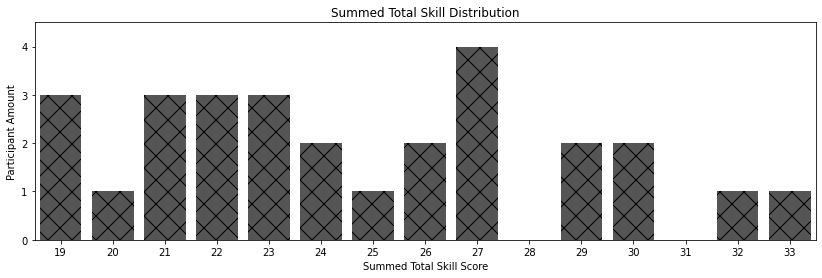

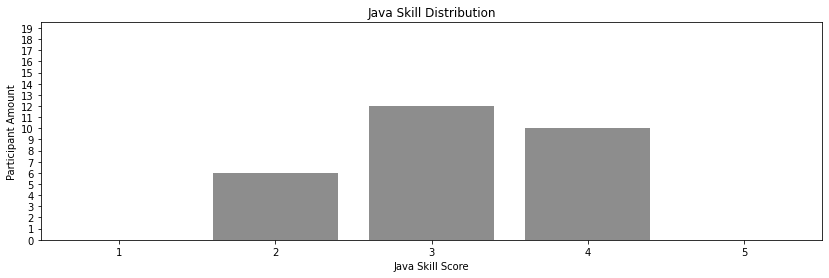

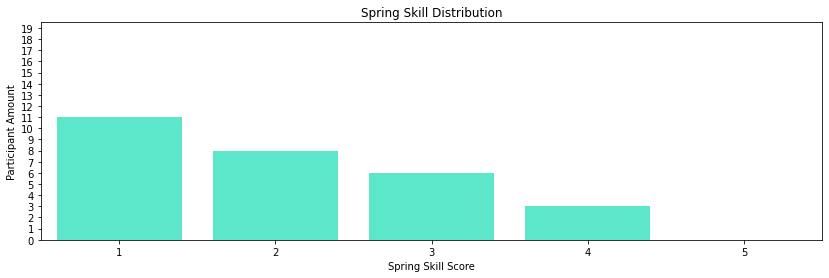

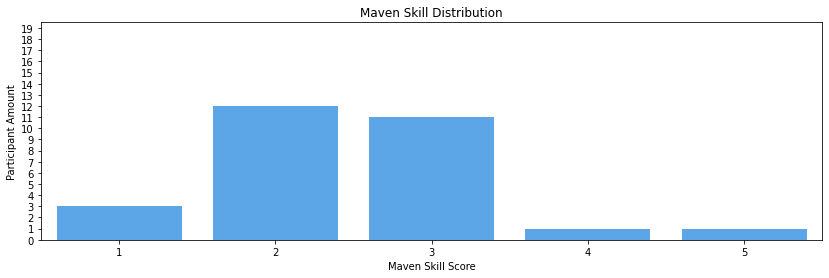

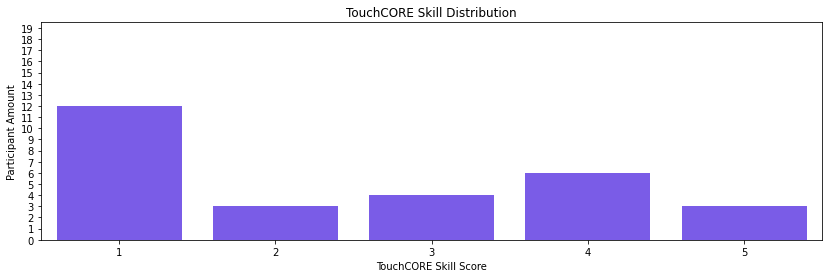

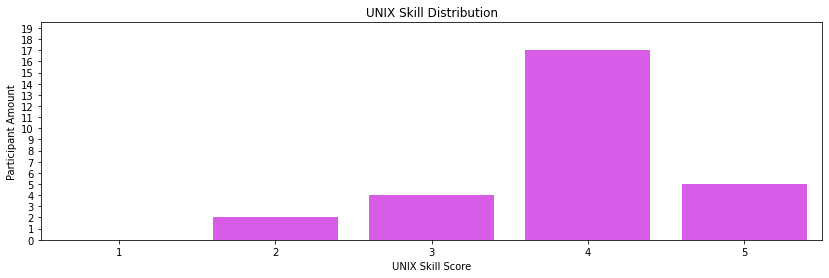

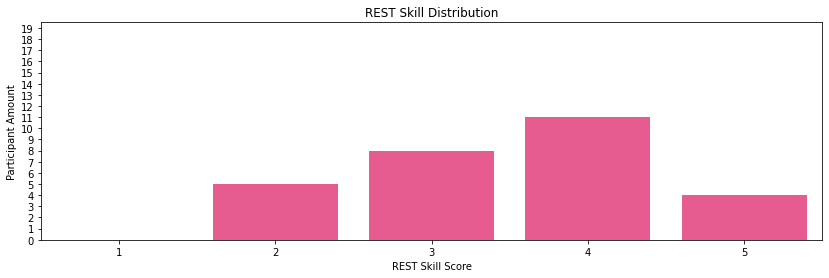

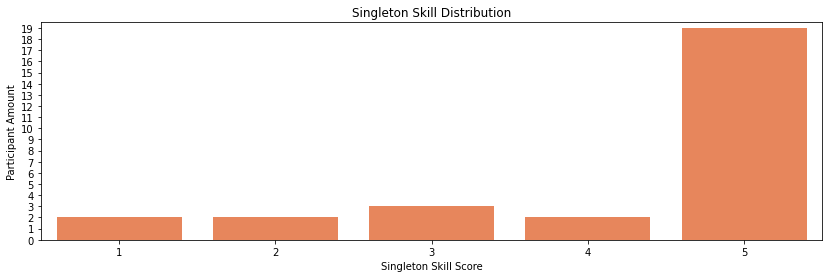

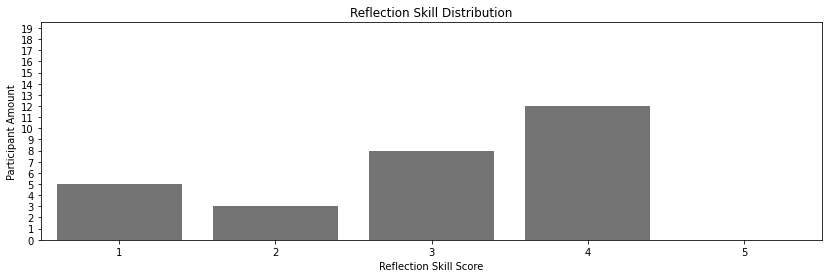

In [7]:
from jupyter_snippets.pseudo_cell_01_display_population_skill_stats import cell_01

cell_01()

#### Interpretation

We acknowledge the extracted distributions vary by skill. Yet we also observe a strong diversity in the population, which we deem a positive factor toward the expriment's robustness.
We also recognize that the profiles remain a self-declared assessment, and by nature is prone to subjective biases due to false estimations of the own skills.
In case of the participant who scored best, we also suspect at least one upfront dishonest declaration, where the associated participant performed extremely poor. We believe the participant had no interest in actual task solving and targeted uniquely the 100 Canadian Dollar gift card issued to participants as compensation. The participant is marked as outlier wherever applicable.

### Control groups

The purpose of the experiment was a comparison of the two aforementioned methodologies, regarding task solving effects. However, to ensure fairness, we could not simply ask each participant to first refactor using *Methodology A*, followed by refactoring the same application with *Methodology B*, as there are multiple potential learning affects to consider:

  * Learning effect from the application context: The first and the second task should not concern the same codebase. We eliminated this effect by alternating between two representative refactoring contexts of comparable complexity:
    * The BookStore, a vanilla e-commerce application representing assortment, comments and stock information for a book vendor.
    * Xox, a vanilla board game application representing an action oriented implementation of Tic Tac Toe.
  * Potentially unfair advantage due to the application or methodology order:
    * Half the population should begin with *Application 1*, the other half should start with *Application 2*.
    * Half the population should begin with *Methodology A*, while the remainder should begin with *Methodology B*

We decided to divide the population into four control groups (*Red*, *Green*, *Blue* and *Yellow)* with different task methodology and context order. This setup showcases several advantages:

  * Statistical observations on the full population automatically level out any potential advantages from a specific order, as we hold the equal participant amount for either variant.
  * We can assess the effects of a specific task order, methodology or contextual combination, by comparison of the corresponding control group to the remaining population.

The below figure illustrates the effective task orders for the individual control groups:
<div>
<img src="static-figures/salad.png" width="360"/>
</div>

TODO: change methodology enumeration to roman letters in figure.

The red square labelled "1" indicates the task details for the first refactoring task of the red control group. In this case it lies in the first quadrant, meaning participants were asked to refactor *Application 1 / E-Commerce* (the BookStore), using *Methodology A / MDE* (The DSML approach with TouchCORE). Similar the red square labelled "2" indicates a task where *Application 2 / Boar Game* (Tic Tac Toe) must be refactored using *Methodology B* (IDE on the example of IntelliJ).

 > Whatever the control group, all task sequences lie on a main diagonals. Furthermore, every group has a symmetric counterpart to offset learning effects in statistics for the full population.

#### Finding a fair partition

Although the above partition into complementary control groups offsets learning effects, experiment fairness also depends on a fair group repartition. That is to say the individual control groups must be comparable in terms of their skill profiles.
For instance, we want to avoid any situation where all participants which high technical proficiency end up in one control group and while complementary participants with profound experience are gathered in another.

We deem the total population size of 28 insufficient to purely rely on stochastic balancing effects. We therefore implemented an algorithm to search for an optimized participant repartition.
While the population is still too large to test all potential combinations for viability, we were able to implement [a MiniMax heuristic, that is to say an algorithm that iteratively works toward a viable repartition by minimizing what hinders comparability](https://en.wikipedia.org/wiki/Minimax). Namely, we searched to minimize the maximum distance in average skill proficiency between two control groups. The fully documented sources of our partition algorithm are [publicly available](https://github.com/m5c/RecruitmentFormInterpreter).
Tho software also allows brute force testing force placement of replacement participants, which was unfortunately necessary, as recruited participants repeatedly retracted from the study, or ceased any form of communicated, even after a fraction of the results was already collected.

The below boxplot shows the effective comparability of the final stable population. Every skill is represented by a series of four coloured boxplots, where each plot represents one control group. Ideally we would see the exact boxplot for each control group, that is to say equal mean (represented by a square) and equal distribution (represented by the whiskers).



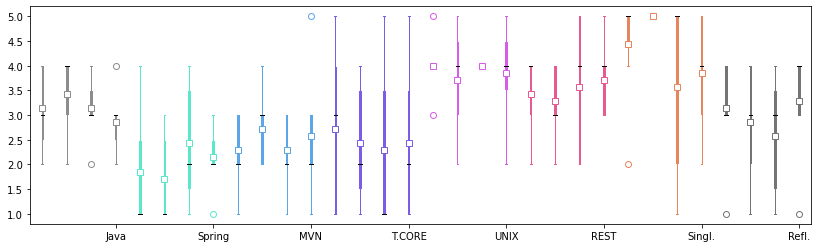

In [8]:
from jupyter_snippets.pseudo_cell_02_display_cgroups_skill_boxplot import cell_02

cell_02()

Due to the heuristic nature of our algorithm and iterative recruitment phases (to replace retractions), the above distribution is not the best possible option under the given metric.

Nonetheless, we note reasonably comparable skill distributions for all control groups, regardless which skill is considered.

It is likewise possible to quantify the *damaging effect* under the applied metric. Below listing shows the average minimum and maximum skill value for any pair of control groups and any skill.

We retain that the largest offset in terms of average skill offset occurs for proficiency with the *Singleton Pattern*, resulting in an offset of ```1.4``` points on a scale of 1-5.

In [9]:
from jupyter_snippets.pseudo_cell_04_compute_cgroup_skill_diffs import cell_04
from jupyter_snippets.pseudo_cell_03_merge_csvs import cell_03

cell_03()
cell_04()

<_io.TextIOWrapper name='source-csv-files/skills.csv' mode='r' encoding='utf-8'>
Control group comparability analysis. Listing of the greatest differences (average skill values) between any pairs of control groups:
Java	: 	AVG_MIN=2.9,	AVG_MAX=, 3.4,	MAX_AVG_DIFF=0.6
Spring	: 	AVG_MIN=1.7,	AVG_MAX=, 2.4,	MAX_AVG_DIFF=0.7
MVN	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
T.CORE	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
UNIX	: 	AVG_MIN=3.7,	AVG_MAX=, 4.0,	MAX_AVG_DIFF=0.3
REST	: 	AVG_MIN=3.3,	AVG_MAX=, 3.7,	MAX_AVG_DIFF=0.4
Singl.	: 	AVG_MIN=3.6,	AVG_MAX=, 5.0,	MAX_AVG_DIFF=1.4
Refl.	: 	AVG_MIN=2.6,	AVG_MAX=, 3.3,	MAX_AVG_DIFF=0.7
--------------
The worst difference in average skill values between two control groups in the given partition appears for:
	"Singleton", with a difference of 1.4


# CONTINUE WRITING HERE

FIRST: explain how time was measured, how correctenss was measured.

## Step 2 - Fusing the data (Redundant?)

TODO: Convert mention of fused CSV to note.

Throughout the experiment we measured different metrics per participant. Those are stored in separate CSV files. Some of them were auto-generated by additional scripts, some were created by hand.
In a first step we are going to fuse all individual CSV files, using the *participant codename* as key. The codename consists of a colour and an animal.

 > We used a total of 4 control groups, *Red*, *Green*, *Blue*, *Yellow*, each starring 7 participants. This setup was chosen to reduce learning effects.

 The outcome of below cell is a new file: ```restify.csv```.
 This file lists all data we ever process in the following, indexed by *participant codename*.

In [10]:
# TODO: print generated CSV content

print("TODO: print actual CSV content here.")

TODO: print actual CSV content here.


# Data Analysis

 * Overall population performance, all methodologies, all applications
    * Overall population performance, manual tasks (percentage)
    * Overall population performance, assisted tasks (percentage)

Here comes a great and intuitive to read text that explains how the unit-test plot is produced and how to read the results.

Key points:

  * Black horizontal bars: all tests failed because the submission did not compile or was not executable.
  * Black vertical bars: A test that failed for many participants.

    TODO: plot needs more labels.

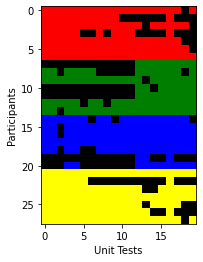

In [11]:
from jupyter_snippets.pseudo_cell_05_all_results_all_participants import cell_05

cell_05()

## Similar, a heatmap with the average test results per control group (TODO, split into applications)

Here comes a great and intuitive to read text that explains how the heatmap plot is produced and how to read the results.


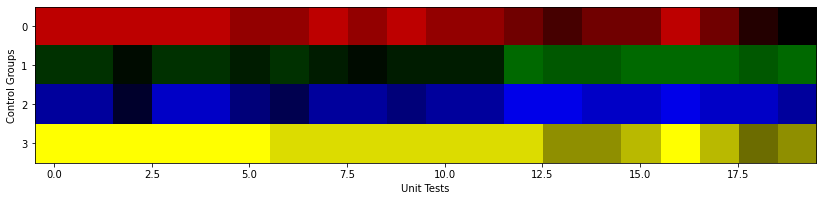

In [12]:
from jupyter_snippets.pseudo_cell_07_all_tests_all_groups import cell_07

cell_07()